In [6]:
# import modules
import warnings
warnings.filterwarnings('ignore')

import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, log_loss, f1_score

import random
from math import floor
from scipy.stats import mode, scoreatpercentile

print("Seaborn version : ", sns.__version__)
sns.set()
#sns.set_style('whitegrid')
sns.set_color_codes()
sns.set_theme(style="ticks", palette="pastel")

Seaborn version :  0.11.1


# 신용카드 사용자 연체 예측 AI 경진대회

- 주제: 신용카드 사용자 데이터를 보고 사용자의 대금 연체 정도를 예측하는 알고리즘 개발 
- 목적: 신용카드 사용자들의 개인 신상정보 데이터로 **사용자의 신용카드 대금 연체 정도를 예측**

- 데이터 설명:
    - **gender :** 고객의 성별, **binary**
    - **car :** 고객의 자차 보유 유무, **binary**
    - **reality :** 고객의 부동산 보유 유무, **binary**
    - **child_num :** 고객의 자녀 수, **integer**
    - **income_total :** 고객의 총 소득, **numeric**
    - **income_type :** 고객의 소득 유형, **category**
    - **edu_type :** 고객의 최종 학력, **category**
    - **family_type :** 고객의 본인의 혼인관련 상태, **category**
    - **house_type :** 고객의 거주지 형태, **category**
    - **DAYS_BIRTH :** (고객의 생일) - (현재 일), **integer**, **numeric**
    - **DAYS_EMPLOYED :** (고객의 첫 고용일) - (현재 일), **numeric**
    - **FLAG_MOBIL :** 고객의 본인 휴대폰 전화번호 등록 여부, **binary**
    - **work_phone :** 고객의 본인 직장 전화번호 등록 여부, **binary**
    - **phone :** 고객의 집 전화번호 등록 여부, **binary**
    - **email :** 고객의 이메일 등록여부, **binary**
    - **occyp_type :** 고객의 고용 형태, **category**
    - **family_size :** 고객의 가족의 크기, **integer**, **numeric**
    - **begin_month :** (고객이 카드를 발급한 월) - (현재 월), **integer**, **numeric**  
    
    - **<u>credit</u>** : 해당 신용카드의 대금 연체 정도 (0,1,2 : 커질수록 대금 연체 정도가 높다. target variable)
    
    
## 학습 목표에 대한 논의
### 학습 목표
- ```Credit``` 변수의 클래스 예측.
    - **classes :** 0, 1, 2
    - **description :** 사용자의 신용카드 대금 연체 정도.  
    - 각 값은 **상대적인 크기**에 대한 정보를 가지고 있다.
    - **imbalaced data**

- 다양한 features가 존재하지만 대부분의 feature에서 class의 비율은 일정하다.

- 데이터 관측치의 기준은 **'사용자'**가 아니라 **'카드'**이다. 
    - 카드 정보에만 해당하는 begin_month를 제외하고 모든 값이 일치하는 관측치는 같은 고객이라고 판단한다.
    - 가설) 카드 사용자를 몇 가지 유형으로 분류 할 수 있고, 유형에 따라 begin_month에 해당하는 credit 값들의 기준이 다르다.
    
- 평가기준:
    - **logloss** : 작을수록 좋은 결과


In [2]:
# upload data
train = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/train.csv',
                   index_col=0)
test = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/test.csv',
                  index_col=0)
submit = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/sample_submission.csv')

In [5]:
# shape of data
print(train.shape)
print(test.shape)

(26457, 19)
(10000, 18)
(10000, 4)


- 데이터는 총 26457개의 관측치와 총 18개의 feature 그리고 target variable로 이루어져있다.
- public score는 test data의 credit variable 을 예측하는 것으로 총 10000개의 데이터를 예측해야한다.

- table
    1. EDA
    2. Preprocessing
    3. modeling
    
---
## EDA
### target variable
- credit

In [29]:
train.credit.value_counts()

2.0    16968
1.0     6267
0.0     3222
Name: credit, dtype: int64

In [30]:
train.credit.value_counts(normalize = True)

2.0    0.641343
1.0    0.236875
0.0    0.121783
Name: credit, dtype: float64

- 전체 train data set 에서 target variable의 class ratio는 약 2:1:0 = **0.64 : 0.23 : 0.12**이다. 클래스 간 불균형이다.

### binary variables
- gender
- car
- reality
- FLAG_MOBIL
- work_phone
- phone
- email

In [54]:
train.FLAG_MOBIL.value_counts()

1    26457
Name: FLAG_MOBIL, dtype: int64

- FLAG_MOBIL의 원소는 결측치 없이 모두 1으로, 변수로써 가치가 없다. -> 제거

In [150]:
print('<binary variables distribution of the train data>\n')
bin_cols = ['gender', 'car', 'reality', 'work_phone', 'phone', 'email']
for cols in bin_cols : 
    print('* Column name : {}'.format(cols))
    print(train[cols].value_counts(),'\n')


<binary variables distribution of the train data>

* Column name : gender
F    17697
M     8760
Name: gender, dtype: int64 

* Column name : car
N    16410
Y    10047
Name: car, dtype: int64 

* Column name : reality
Y    17830
N     8627
Name: reality, dtype: int64 

* Column name : work_phone
0    20511
1     5946
Name: work_phone, dtype: int64 

* Column name : phone
0    18672
1     7785
Name: phone, dtype: int64 

* Column name : email
0    24042
1     2415
Name: email, dtype: int64 



<Figure size 360x720 with 0 Axes>

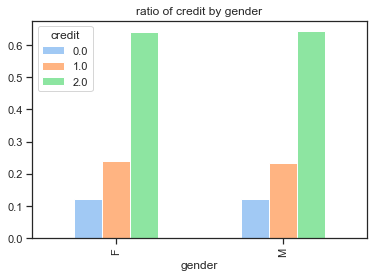

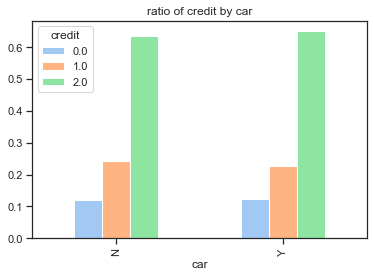

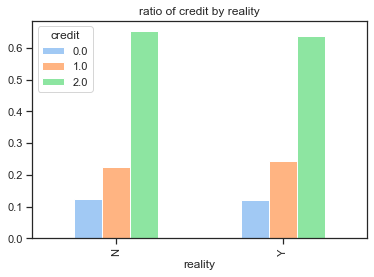

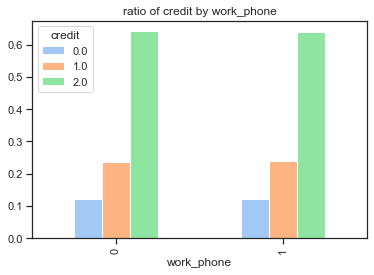

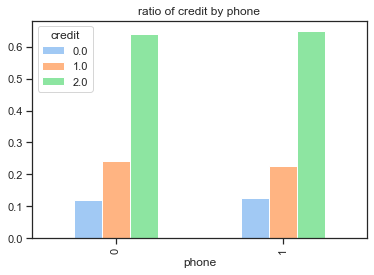

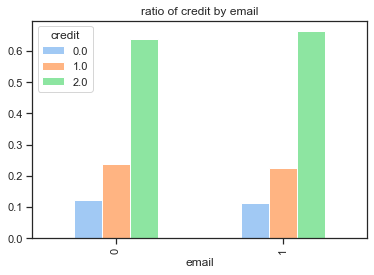

In [112]:
for cols in bin_cols :
    train.groupby(cols).credit.value_counts(normalize = True).unstack().plot(kind = 'bar', title = 'ratio of credit by {}'.format(cols))

- binary columns 에 속하는 'gender', 'car', 'reality', 'work_phone', 'phone', 'email'는 positive와 negative 사이에 credit class간의 비율 차이가 거의 보이지 않는다.


### numeric variables
- child_num
- 

#### child_num
- integer

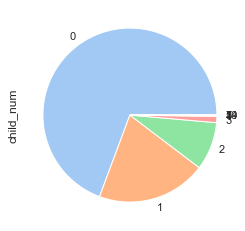

In [151]:
train.child_num.value_counts().sort_index().plot(kind = 'pie')
plt.show()

In [152]:
train.child_num.value_counts().sort_index()

0     18340
1      5386
2      2362
3       306
4        47
5        10
7         2
14        3
19        1
Name: child_num, dtype: int64

- 대부분의 값이 0, 1, 2, 3에 속한다.
- 극히 일부 값들이 7, 14, 19와 같은 값을 지닌다. -> 이상치로 판단하여 train data에서 제거해주도록 한다.

- family_type 변수와의 관계를 통해 family_size가 결정된다.

In [161]:
for f_type in train.family_type.unique() : 
    print('*',f_type)
    print((train.family_size - train.child_num).loc[train.family_type == f_type].value_counts())
    print()
    

* Married
 2.0    18193
 0.0        2
-1.0        1
dtype: int64

* Civil marriage
2.0    2122
0.0       1
dtype: int64

* Separated
1.0    1539
dtype: int64

* Single / not married
1.0    3478
2.0      16
0.0       2
dtype: int64

* Widow
1.0    1103
dtype: int64



- family_size - child_num = (본인+배우자 유무)라는 공식이 성립하는 것으로 보인다.
- 하지만 성립하지 않은 데이터가 존재한다.
    - Married 에서 0에 2개의 관측치, -1에 1개의 관측치
    - Civil marriage에서 0에 1개의 관측치
    - Single / not married 에서 2에 16개 관측치, 0에 2개 관측치
    
- 성립하지 않은 데이터에 대해서 확인해보는 것이 필요하다.